In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import gymnasium as gym
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict

In [5]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'REGULAR'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('1', 'SPECIFIC'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('2', 'REGULAR'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('2', 'SPECIFIC'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 'REGULAR': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'SPECIFIC': {'mu': 4.650110366782741,
  'sigma': 0.01083819523964822,
  'loc': -5.260938954957395},
 'REGULAR_x4': {'mu': 5.145228282554465,
  'sigma': 0.006121000886257698,
  'loc': -11.387033615361277},
 'SPECIFIC_x4': {'mu': 6.036404727902634,
  'sigma': 0.002709623408600959,
  'loc': -21.043755819830228}}

In [6]:
with open('pickles/anonbank_service_rate.pkl', 'rb') as f:
    service_rate = pickle.load(f)

# Convert service_rate to a dictionary for easier access
ser_rate_dict = service_rate.set_index(['group', 'type_group'])[['mean_service_time', 'std']].to_dict('index')

ser_rate_dict

{('1', 'REGULAR'): {'mean_service_time': 12.641068214208262,
  'std': 274.09685054233046},
 ('1', 'SPECIFIC'): {'mean_service_time': 14.229164478664519,
  'std': 447.916748807343},
 ('2', 'REGULAR'): {'mean_service_time': 19.02417781821472,
  'std': 344.9407640049321},
 ('2', 'SPECIFIC'): {'mean_service_time': 15.020757462895316,
  'std': 257.32365209990894}}

In [7]:

# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = regular, 1 = specific
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [1, 2]

# Arrival parameters for regular and specific calls
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']
ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

SERVICE_REGULAR_1_MU = lognorm_params_dict[('1', 'REGULAR')]['mu']
SERVICE_REGULAR_1_SIGMA = lognorm_params_dict[('1', 'REGULAR')]['sigma']
SERVICE_REGULAR_1_LOC = lognorm_params_dict[('1', 'REGULAR')]['loc']
SERVICE_SPECIFIC_1_MU = lognorm_params_dict[('1', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_1_SIGMA = lognorm_params_dict[('1', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_1_LOC = lognorm_params_dict[('1', 'SPECIFIC')]['loc']

SERVICE_REGULAR_2_MU = lognorm_params_dict[('2', 'REGULAR')]['mu']
SERVICE_REGULAR_2_SIGMA = lognorm_params_dict[('2', 'REGULAR')]['sigma']
SERVICE_REGULAR_2_LOC = lognorm_params_dict[('2', 'REGULAR')]['loc']
SERVICE_SPECIFIC_2_MU = lognorm_params_dict[('2', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_2_SIGMA = lognorm_params_dict[('2', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_2_LOC = lognorm_params_dict[('2', 'SPECIFIC')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

def std_shifted_lognormal(mu, sigma, loc):
    """
    Calculate standard deviation of shifted lognormal distribution:
    The location (loc) shifts the mean but does not affect the std.
    """
    return np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))

# Arrival rates

ARRIVAL_REGULAR = mean_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC
)

ARRIVAL_SPECIFIC = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

ARRIVAL_REGULAR_STD = std_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC   
)

ARRIVAL_SPECIFIC_STD = std_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

# Service means and std

SERVICE_REGULAR_1 = ser_rate_dict[('1', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_1 = ser_rate_dict[('1', 'SPECIFIC')]['mean_service_time']
SERVICE_REGULAR_2 = ser_rate_dict[('2', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_2 = ser_rate_dict[('2', 'SPECIFIC')]['mean_service_time']

SERVICE_REGULAR_1_STD = ser_rate_dict[('1', 'REGULAR')]['std']
SERVICE_SPECIFIC_1_STD = ser_rate_dict[('1', 'SPECIFIC')]['std']
SERVICE_REGULAR_2_STD = ser_rate_dict[('2', 'REGULAR')]['std']
SERVICE_SPECIFIC_2_STD = ser_rate_dict[('2', 'SPECIFIC')]['std']

# SERVICE_REGULAR_1 = mean_shifted_lognormal(
#     SERVICE_REGULAR_1_MU,
#     SERVICE_REGULAR_1_SIGMA,
#     SERVICE_REGULAR_1_LOC
# )

# SERVICE_REGULAR_2 = mean_shifted_lognormal(
#     SERVICE_REGULAR_2_MU,
#     SERVICE_REGULAR_2_SIGMA,
#     SERVICE_REGULAR_2_LOC
# )

# SERVICE_SPECIFIC_1 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_1_MU,
#     SERVICE_SPECIFIC_1_SIGMA,
#     SERVICE_SPECIFIC_1_LOC
# )

# SERVICE_SPECIFIC_2 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_2_MU,
#     SERVICE_SPECIFIC_2_SIGMA,
#     SERVICE_SPECIFIC_2_LOC
# )

In [8]:
print("MEANS:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2}") 

print("STD:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR_STD}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC_STD}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1_STD}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1_STD}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2_STD}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2_STD}")

MEANS:
ARRIVAL_REGULAR: 40.068763243462236, ARRIVAL_SPECIFIC: 99.34173344076834
SERVICE_REGULAR_1: 12.641068214208262, SERVICE_SPECIFIC_1: 14.229164478664519
SERVICE_REGULAR_2: 19.02417781821472, SERVICE_SPECIFIC_2: 15.020757462895316
STD:
ARRIVAL_REGULAR: 1.050753626188135, ARRIVAL_SPECIFIC: 1.1337374798875093
SERVICE_REGULAR_1: 274.09685054233046, SERVICE_SPECIFIC_1: 447.916748807343
SERVICE_REGULAR_2: 344.9407640049321, SERVICE_SPECIFIC_2: 257.32365209990894


In [9]:
# Lognormal expected value calculation

def expected_waiting_time_binom_kingman(q_size, p_regular, mean_r, mean_s, rho, ca, cs):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    EWq = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        EWq += prob * wait_k
        
    # Kingman scaling
    Km = rho / (1 - rho) * (ca ** 2 + cs ** 2) / 2

    return EWq * Km

def expected_waiting_time_binom(q_size, p_regular, mean_r, mean_s):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        wait += prob * wait_k

    return wait

def rho(rate_regular, rate_specific, mean_r, mean_s):
    """
    Calculate the traffic intensity (rho) for the queue.
    """
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_r) + (rate_specific / rate_total * mean_s)
    
    rhoo = rate_total * mean_comb
    if rhoo >= 1:
        return float('inf')  # Avoid division by zero or negative values
    return rhoo

def cv2(var, mean):
    return var / (mean ** 2)

def combined_ca2(rate_regular, rate_specific, ca_regular, ca_specific):
    """
    Calculate the combined coefficient of variation squared for the arrival process.
    """
    rate_total = rate_regular + rate_specific
    
    return (rate_regular / rate_total) * ca_regular + (rate_specific / rate_total) * ca_specific

def combined_cs2(mean_regular, mean_specific, cs_regular, cs_specific):
    """
    Calculate the combined coefficient of variation squared for the service process.
    """
    rate_regular = 1 / mean_regular
    rate_specific = 1 / mean_specific
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_regular) + (rate_specific / rate_total * mean_specific)
    
    term1 = (rate_regular / rate_total) * cs_regular
    term2 = (rate_specific / rate_total) * cs_specific
    term3 = rate_regular / rate_total * ((mean_regular - mean_comb) / mean_comb) ** 2
    term4 = rate_specific / rate_total * ((mean_specific - mean_comb) / mean_comb) ** 2
    
    return term1 + term2 + term3 + term4

In [10]:
# Example usage to calculate expected waiting time for queue 1:

rate_regular = 1 / ARRIVAL_REGULAR
rate_specific = 1 / ARRIVAL_SPECIFIC
rate_total = rate_regular + rate_specific

p_regular = rate_regular / rate_total

mean_r1 = SERVICE_REGULAR_1
mean_s1 = SERVICE_SPECIFIC_1

rho1 = rho(rate_regular, rate_specific, mean_r1, mean_s1)

meana_r = ARRIVAL_REGULAR
meana_s = ARRIVAL_SPECIFIC
vara_r = ARRIVAL_REGULAR_STD ** 2
vara_s = ARRIVAL_SPECIFIC_STD ** 2

ca_r = cv2(vara_r, meana_r)
ca_s = cv2(vara_s, meana_s)

vars_r1 = SERVICE_REGULAR_1_STD ** 2
vars_s1 = SERVICE_SPECIFIC_1_STD ** 2

cs_r1 = cv2(vars_r1, mean_r1)
cs_s1 = cv2(vars_s1, mean_s1)

ca = combined_ca2(rate_regular, rate_specific, ca_r, ca_s)
cs_1 = combined_cs2(mean_r1, mean_s1, cs_r1, cs_s1)

q_size = 10 # Example queue size

expected_wait = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r1, mean_s1, rho1, ca, cs_1)
print(f"Expected waiting time at queue 1 (Kingman): {expected_wait:.4f}")

# Compare with queue 2

mean_r2 = SERVICE_REGULAR_2
mean_s2 = SERVICE_SPECIFIC_2

rho2 = rho(rate_regular, rate_specific, mean_r2, mean_s2)

vars_r2 = SERVICE_REGULAR_2_STD ** 2
vars_s2 = SERVICE_SPECIFIC_2_STD ** 2

cs_r2 = cv2(vars_r2, mean_r2)
cs_s2 = cv2(vars_s2, mean_s2)

cs_2 = combined_cs2(mean_r2, mean_s2, cs_r2, cs_s2)

expected_wait2 = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r2, mean_s2, rho2, ca, cs_2)
print(f"Expected waiting time at queue 2 (Kingman): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Kingman): 28384089.2543
Expected waiting time at queue 2 (Kingman): 14287191.6796


In [11]:
expected_wait = expected_waiting_time_binom(q_size, p_regular, mean_r1, mean_s1)
print(f"Expected waiting time at queue 1 (Binom): {expected_wait:.4f}")
expected_wait2 = expected_waiting_time_binom(q_size, p_regular, mean_r2, mean_s2)
print(f"Expected waiting time at queue 2 (Binom): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Binom): 130.9751
Expected waiting time at queue 2 (Binom): 178.7353


In [12]:
# Calculate departure probability
r1_rate = 1 / mean_r1
r2_rate = 1 / mean_r2
s1_rate = 1 / mean_s1
s2_rate = 1 / mean_s2

total_rate = rate_regular + rate_specific + r1_rate + r2_rate + s1_rate + s2_rate

print(f"Departure probability for REGULAR, Queue 1: {r1_rate / total_rate:.4f}")
print(f"Departure probability for REGULAR, Queue 2: {r2_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 1: {s1_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 2: {s2_rate / total_rate:.4f}")

Departure probability for REGULAR, Queue 1: 0.2606
Departure probability for REGULAR, Queue 2: 0.1732
Departure probability for SPECIFIC, Queue 1: 0.2315
Departure probability for SPECIFIC, Queue 2: 0.2193


### Use binomial expected waiting time

In [ ]:
class CallCentreMDPEnv(gym.Env):
    """
    RL environment for a two-queue call centre with mixed call types.
    State: (queue1_length, queue2_length, call_type)
    Action: 0 = route to queue 1, 1 = route to queue 2
    Reward: Negative expected waiting time (cost to minimise)
    """
    
    def __init__(self, 
                 max_queue_size=10,
                 drop_penalty=1000.0,
                 arrival_regular_mean=None,
                 arrival_specific_mean=None,
                 service_regular_1=None,
                 service_specific_1=None,
                 service_regular_2=None,
                 service_specific_2=None,
                 time_step=1.0,  # Duration of each step in seconds
                 seed=None):
        """
        Initialize the call centre environment with lognormal inter-arrival times.
        """
        super().__init__()
        
        self.max_queue_size = max_queue_size
        self.drop_penalty = drop_penalty
        self.time_step = time_step
        
        # Service parameters
        self.service_times = {
            (1, 'regular'): service_regular_1 or SERVICE_REGULAR_1,
            (1, 'specific'): service_specific_1 or SERVICE_SPECIFIC_1,
            (2, 'regular'): service_regular_2 or SERVICE_REGULAR_2,
            (2, 'specific'): service_specific_2 or SERVICE_SPECIFIC_2,
        }
        
        # Lognormal arrival parameters
        self.arrival_params = {
            'regular': {
                'mu': ARRIVAL_REGULAR_MU,
                'sigma': ARRIVAL_REGULAR_SIGMA,
                'loc': ARRIVAL_REGULAR_LOC,
                'mean': arrival_regular_mean or ARRIVAL_REGULAR
            },
            'specific': {
                'mu': ARRIVAL_SPECIFIC_MU,
                'sigma': ARRIVAL_SPECIFIC_SIGMA,
                'loc': ARRIVAL_SPECIFIC_LOC,
                'mean': arrival_specific_mean or ARRIVAL_SPECIFIC
            }
        }
        
        # Calculate arrival rates (for probability calculations)
        arrival_regular_rate = 1.0 / self.arrival_params['regular']['mean']
        arrival_specific_rate = 1.0 / self.arrival_params['specific']['mean']
        self.total_arrival_rate = arrival_regular_rate + arrival_specific_rate
        
        # Probability that an arriving call is regular
        self.p_regular = arrival_regular_rate / self.total_arrival_rate
        
        # Calculate service rates and completion probabilities
        service_rates = {
            group_call: 1.0 / service_time 
            for group_call, service_time in self.service_times.items()
        }
        
        self.completion_prob = {
            group_call: min(1.0, service_rates[group_call] * self.time_step)
            for group_call in service_rates
        }
        
        # Initialize arrival tracking
        self.time_to_next_regular = self._generate_lognormal_interarrival('regular')
        self.time_to_next_specific = self._generate_lognormal_interarrival('specific')
        self.current_time = 0.0
        
        # Debug output
        print(f"Time step: {self.time_step} seconds")
        print(f"Lognormal arrival means: Regular={self.arrival_params['regular']['mean']:.1f}s, Specific={self.arrival_params['specific']['mean']:.1f}s")
        
        # Calculate expected arrivals per episode for different episode lengths
        expected_regular_per_100_steps = (100 * self.time_step) / self.arrival_params['regular']['mean']
        expected_specific_per_100_steps = (100 * self.time_step) / self.arrival_params['specific']['mean']
        total_expected_per_100_steps = expected_regular_per_100_steps + expected_specific_per_100_steps
        
        print(f"Expected arrivals per 100 steps: Regular={expected_regular_per_100_steps:.2f}, Specific={expected_specific_per_100_steps:.2f}, Total={total_expected_per_100_steps:.2f}")
        
        if total_expected_per_100_steps < 2.0:
            recommended_time_step = (2.0 * 100) / (100 / self.arrival_params['regular']['mean'] + 100 / self.arrival_params['specific']['mean'])
            print(f"⚠️  WARNING: Very few arrivals expected! Consider time_step >= {recommended_time_step:.1f}s")
        
        print("Completion probabilities per step:")
        for key, prob in self.completion_prob.items():
            print(f"  {key}: {prob:.4f}")
        
        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]), 
            high=np.array([max_queue_size, max_queue_size, 1]), 
            dtype=np.int32
        )
        
        self.action_space = spaces.Discrete(2)
        
        # Initialize state
        self.queue_lengths = [0, 0]
        self.pending_calls = []  # List of (call_type, call_type_str) tuples
        
        if seed is not None:
            self.seed(seed)
    
    def _generate_lognormal_interarrival(self, call_type):
        """Generate next inter-arrival time using lognormal distribution."""
        params = self.arrival_params[call_type]
        
        # Generate from lognormal distribution
        sample = np.random.lognormal(params['mu'], params['sigma'])
        # Add location parameter (shift)
        interarrival_time = sample + params['loc']
        
        return max(interarrival_time, 0.1)  # Ensure minimum time between arrivals
    
    def seed(self, seed=None):
        """Set random seed for reproducibility."""
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.np_random = np.random.RandomState(seed)
    
    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        if seed is not None:
            self.seed(seed)
        
        self.queue_lengths = [0, 0]
        self.pending_calls = []
        self.current_time = 0.0
        
        # Reset next arrival times
        self.time_to_next_regular = self._generate_lognormal_interarrival('regular')
        self.time_to_next_specific = self._generate_lognormal_interarrival('specific')
        
        # Check for any arrivals at time 0
        self._process_arrivals()
        
        return self._get_state(), {}
    
    def _process_arrivals(self):
        """Process arrivals using lognormal inter-arrival times."""
        # Advance time
        self.current_time += self.time_step
        
        # Check for regular call arrivals
        while self.current_time >= self.time_to_next_regular:
            self.pending_calls.append((0, 'regular'))
            # Generate next regular call arrival time
            next_interarrival = self._generate_lognormal_interarrival('regular')
            self.time_to_next_regular += next_interarrival
        
        # Check for specific call arrivals
        while self.current_time >= self.time_to_next_specific:
            self.pending_calls.append((1, 'specific'))
            # Generate next specific call arrival time
            next_interarrival = self._generate_lognormal_interarrival('specific')
            self.time_to_next_specific += next_interarrival
    
    def _get_state(self):
        """Get current state as numpy array."""
        # If no pending calls, return state with random call type
        if not self.pending_calls:
            current_call_type = np.random.choice([0, 1], p=[self.p_regular, 1-self.p_regular])
        else:
            # Use the first pending call's type
            current_call_type = self.pending_calls[0][0]
            
        return np.array([
            self.queue_lengths[0], 
            self.queue_lengths[1], 
            current_call_type
        ], dtype=np.int32)
    
    def expected_waiting_time_binomial(self, queue_idx, call_type):
        """Calculate expected waiting time using binomial mixture of call types."""
        queue_size = self.queue_lengths[queue_idx]
        
        if queue_size == 0:
            return 0.0
        
        # Service times for this queue
        mean_regular = self.service_times[(queue_idx + 1, 'regular')]
        mean_specific = self.service_times[(queue_idx + 1, 'specific')]
        
        # Calculate expected waiting time using binomial mixture
        expected_wait = 0.0
        for k in range(queue_size + 1):
            prob = comb(queue_size, k) * (self.p_regular ** k) * ((1 - self.p_regular) ** (queue_size - k))
            wait_time = k * mean_regular + (queue_size - k) * mean_specific
            expected_wait += prob * wait_time
        
        return expected_wait
    
    def step(self, action):
        """Execute action and return next state, reward, done, info."""
        reward = 0.0
        dropped = False
        expected_wait = 0.0
        call_type_str = 'none'
        
        # Handle the current call (first in pending_calls if any exist)
        if self.pending_calls:
            call_type, call_type_str = self.pending_calls.pop(0)
            
            # Check if queue is full
            if self.queue_lengths[action] >= self.max_queue_size:
                reward = -self.drop_penalty
                dropped = True
                expected_wait = None
            else:
                expected_wait = self.expected_waiting_time_binomial(action, call_type)
                reward = -expected_wait
                self.queue_lengths[action] += 1
                dropped = False
        
        # Process queue completions
        self._process_queues()
        
        # Process new arrivals based on lognormal inter-arrival times
        self._process_arrivals()
        
        # Determine if episode should continue
        terminated = False
        truncated = False
        
        info = {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'chosen_queue': action + 1 if not dropped and call_type_str != 'none' else None,
            'expected_wait': expected_wait,
            'dropped': dropped,
            'reward': reward,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time,
            'next_regular_in': self.time_to_next_regular - self.current_time,
            'next_specific_in': self.time_to_next_specific - self.current_time
        }
        
        return self._get_state(), reward, terminated, truncated, info
    
    def _process_queues(self):
        
        for i in range(2):
            q_len = self.queue_lengths[i]
            if q_len > 0:
                group = i + 1
                completions = 0
                reducer = 1.0
                
                for _ in range(q_len):
                    call_type = 'regular' if np.random.random() < self.p_regular else 'specific'
                    base_prob = self.completion_prob.get((group, call_type), 0)
                    adjusted_prob = base_prob * reducer
                    if np.random.random() < adjusted_prob:
                        completions += 1
                        reducer *= (q_len - completions) / q_len  # Adjust reducer based on remaining calls
                
                new_len = max(0, q_len - completions)
                self.queue_lengths[i] = new_len
    
    def render(self, mode='human'):
        """Render current state."""
        state = self._get_state()
        call_type_str = 'Regular' if state[2] == 0 else 'Specific'
        print(f"Time: {self.current_time:.1f}s | Queue 1: {self.queue_lengths[0]:2d} | Queue 2: {self.queue_lengths[1]:2d} | Next Call: {call_type_str} | Pending: {len(self.pending_calls)}")
    
    def get_state_info(self):
        """Get detailed state information for analysis."""
        state = self._get_state()
        call_type_str = 'Regular' if state[2] == 0 else 'Specific'
        
        wait_q1 = self.expected_waiting_time_binomial(0, state[2]) if len(self.pending_calls) > 0 else 0
        wait_q2 = self.expected_waiting_time_binomial(1, state[2]) if len(self.pending_calls) > 0 else 0
        
        return {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'p_regular': self.p_regular,
            'expected_wait_q1': wait_q1,
            'expected_wait_q2': wait_q2,
            'optimal_choice': 1 if wait_q1 <= wait_q2 else 2,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time
        }

In [14]:
def q_learning_with_debugging(
    env,
    num_episodes=10000,
    max_steps_per_episode=200,
    alpha=0.2,
    gamma=0.9,
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
):
    """
    Q-learning with debugging information and proper gym environment handling.
    """
    Q = defaultdict(lambda: np.zeros(2))  # Two actions: queue 1 or 2
    episode_costs = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        # Reset returns (state, info) tuple
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
            else:
                action = int(np.argmax(Q[state_tuple]))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Q-learning update
            best_next_action = np.argmax(Q[next_state_tuple])
            td_target = reward + gamma * Q[next_state_tuple][best_next_action]
            td_error = td_target - Q[state_tuple][action]
            Q[state_tuple][action] += alpha * td_error
            
            state_tuple = next_state_tuple
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(-total_reward)  # Convert reward to positive cost
        
        # Progress logging
        if (episode + 1) % 2000 == 0:
            avg_cost = np.mean(episode_costs[-2000:])
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {avg_cost:.2f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States explored: {len(Q)}\n")
    
    return Q, episode_costs

In [15]:
def evaluate_policy(env, Q_table, num_episodes=100, policy_name="Q-Learning"):
    """Evaluate a deterministic policy learned via Q-table."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            state_tuple = tuple(state)

            # Choose action deterministically (greedy)
            if state_tuple in Q_table:
                action = int(np.argmax(Q_table[state_tuple]))
            else:
                action = 0  # Default: route to queue 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print(f"{policy_name} Policy Evaluation:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [16]:
def shortest_queue_baseline(env, num_episodes=100):
    """Baseline: always choose the shorter queue."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            q1, q2, call_type = state

            # Choose shorter queue, with tie-breaking
            if q1 < q2:
                action = 0  # queue 1
            elif q2 < q1:
                action = 1  # queue 2
            else:
                # Tie-break: regular calls to queue 1, specific to queue 2
                action = 0 if call_type == 0 else 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print("Shortest Queue Baseline:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [17]:
def plot_results(costs, Q_table, max_queue_size):
    """Plot learning curve and learned policies."""
    
    # Plot learning curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(costs, alpha=0.3, label="Episode Cost")
    window = 100
    if len(costs) > window:
        smoothed = pd.Series(costs).rolling(window).mean()
        plt.plot(smoothed, color='red', linewidth=2, label=f"Smoothed (window={window})")
    plt.title("Q-Learning: Cost vs Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot learned policies
    policy_regular = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
    policy_specific = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)

    for q1 in range(max_queue_size + 1):
        for q2 in range(max_queue_size + 1):
            # Regular call policy
            s_regular = (q1, q2, 0)
            if s_regular in Q_table:
                policy_regular[q1, q2] = np.argmax(Q_table[s_regular])
            
            # Specific call policy
            s_specific = (q1, q2, 1)
            if s_specific in Q_table:
                policy_specific[q1, q2] = np.argmax(Q_table[s_specific])

    # Plot policies
    plt.subplot(1, 3, 2)
    ax = sns.heatmap(np.flipud(policy_regular), cmap="RdYlBu", annot=True, 
                     cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Regular Calls')
    plt.ylabel('Queue 1 Length')
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.subplot(1, 3, 3)
    ax = sns.heatmap(np.flipud(policy_specific), cmap="RdYlBu", annot=True,
                cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Specific Calls')
    plt.ylabel('Queue 1 Length') 
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

In [18]:
if __name__ == "__main__":
    print("Call Centre MDP Environment")
    
    # Set parameters for the environment
    max_queue_size = MAX_QUEUE_SIZE
    drop_penalty = DROP_PENALTY

    # Arrival parameters
    arrival_means = {
        0: ARRIVAL_REGULAR,    # Regular calls
        1: ARRIVAL_SPECIFIC    # Specific calls
    }
    
    # Service parameters
    service_means = {
        (1, 0): SERVICE_REGULAR_1,
        (1, 1): SERVICE_SPECIFIC_1,
        (2, 0): SERVICE_REGULAR_2,
        (2, 1): SERVICE_SPECIFIC_2
    }

    print(f"Regular call probability: {p_regular:.3f}")
    print(f"Service times (mean): Q1 Regular = {service_means[(1,0)]:.1f} s, Specific = {service_means[(1,1)]:.1f} s")
    print(f"                     Q2 Regular = {service_means[(2,0)]:.1f} s, Specific = {service_means[(2,1)]:.1f} s")
    print(f"Arrival times (mean inter-arrival time): Regular = {arrival_means[0]:.1f} s, Specific = {arrival_means[1]:.1f} s")
    print("="*60)

    # Set random seeds for reproducibility
    random.seed(1901448)
    np.random.seed(1901448)
    
    # Arrival scaler
    scaler = 50.0  # Adjust this to get more arrivals per episode

    # Create environment with consistent drop penalty, matching your notebook/class signature
    env = CallCentreMDPEnv(
        max_queue_size=max_queue_size,
        drop_penalty=drop_penalty,
        time_step=100.0,  # 100 second time step
        arrival_regular_mean=arrival_means[0] / scaler,
        arrival_specific_mean=arrival_means[1] / scaler,
        service_regular_1=service_means[(1, 0)],
        service_specific_1=service_means[(1, 1)],
        service_regular_2=service_means[(2, 0)],
        service_specific_2=service_means[(2, 1)],
    )

    # Test environment with a few random steps
    print("\nTesting environment:")
    state, _ = env.reset()
    print(f"Initial state: {state}")

    for i in range(3):
        action = random.choice([0, 1])
        state, reward, terminated, truncated, info = env.step(action)
        cost = -reward
        print(f"Step {i+1}: Action={action+1}, State={state}, Cost={cost:.1f}, Dropped={info['dropped']}")

    print("\n" + "="*60)

    # Evaluate baseline policy
    print("BASELINE EVALUATION:")
    baseline_cost, _, _ = shortest_queue_baseline(env, num_episodes=1000)

    print("\n" + "="*60)

    # Train Q-learning agent
    print("Q-LEARNING TRAINING:")
    Q_table, costs = q_learning_with_debugging(
        env,
        num_episodes=50000,
        epsilon_min=0.01,
        epsilon_decay=0.9999,
        alpha=0.01
    )

    print("="*60)

    # Evaluate learned policy
    print("LEARNED POLICY EVALUATION:")
    learned_cost, _, _ = evaluate_policy(env, Q_table, num_episodes=1000)

    print("="*60)
    print("FINAL COMPARISON:")
    print(f"Baseline (Shortest Queue): {baseline_cost:.2f}")
    print(f"Q-Learning Policy:         {learned_cost:.2f}")
    improvement = baseline_cost - learned_cost
    print(f"Improvement:               {improvement:.2f}")

    if improvement > 0:
        print("✅ Q-Learning is BETTER (lower cost)")
    else:
        print("❌ Q-Learning is WORSE (higher cost)")

    percent_impr = (improvement / baseline_cost) * 100 if baseline_cost > 0 else 0.0
    print(f"Percentage improvement:    {percent_impr:.2f}%")


Call Centre MDP Environment
Regular call probability: 0.713
Service times (mean): Q1 Regular = 12.6 s, Specific = 14.2 s
                     Q2 Regular = 19.0 s, Specific = 15.0 s
Arrival times (mean inter-arrival time): Regular = 40.1 s, Specific = 99.3 s
Time step: 100.0 seconds
Lognormal arrival means: Regular=0.8s, Specific=2.0s
Expected arrivals per 100 steps: Regular=12478.55, Specific=5033.13, Total=17511.68
Completion probabilities per step:
  (1, 'regular'): 0.0392
  (1, 'specific'): 0.0348
  (2, 'regular'): 0.0260
  (2, 'specific'): 0.0330

Testing environment:
Initial state: [0 0 0]
Step 1: Action=2, State=[0 1 0], Cost=0.0, Dropped=False
Step 2: Action=2, State=[0 2 0], Cost=17.9, Dropped=False
Step 3: Action=2, State=[0 3 0], Cost=35.7, Dropped=False

BASELINE EVALUATION:
Shortest Queue Baseline:
  Average cost per episode: 37510.58 ± 3975.28
  Drop rate: 0.0008 (163/200000)

Q-LEARNING TRAINING:
Episode 2000/50000
  Avg Cost (last 2000): 47891.28
  Epsilon: 0.7369
  Stat

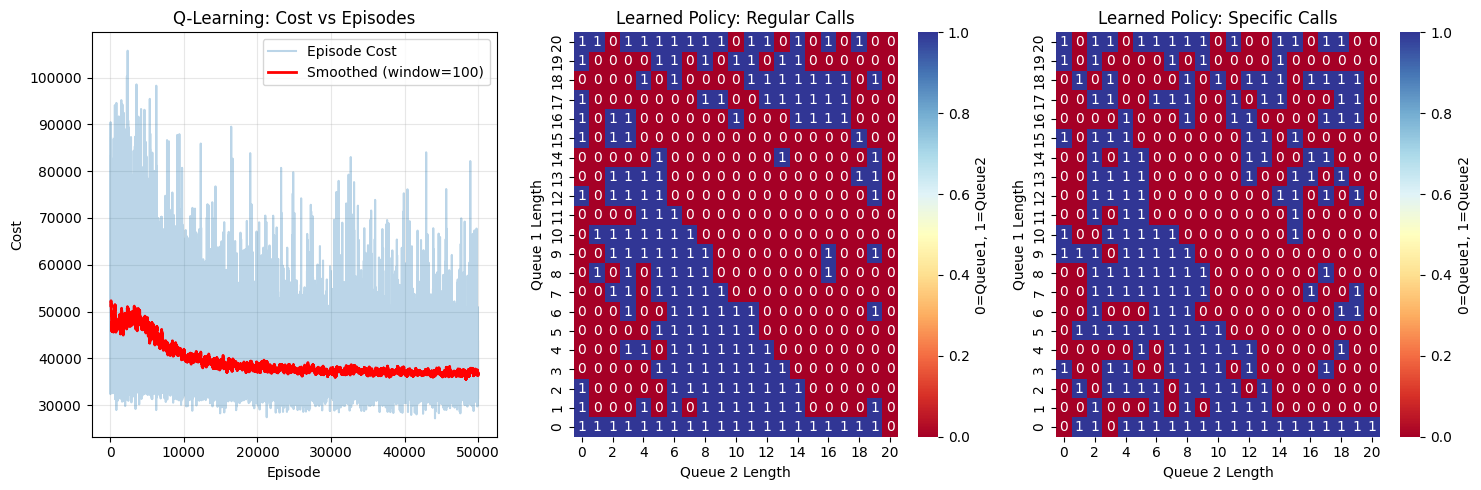

In [19]:
plot_results(costs, Q_table, max_queue_size)

In [28]:
def improved_q_learning(
    env,
    num_episodes=20000,
    max_steps_per_episode=100,
    alpha=0.1,  # Lower learning rate for stability
    gamma=0.99, # High discount for long-term thinking
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
):
    """
    Improved Q-learning specifically optimized for the call centre environment.
    Includes better exploration, stability, and monitoring.
    """
    
    # Initialize Q-table with small random values to break ties
    Q = defaultdict(lambda: np.random.normal(0, 0.01, 2))
    
    episode_costs = []
    episode_rewards = []
    optimal_action_counts = []
    epsilon = epsilon_start
    
    # Track learning progress
    learning_stats = {
        'states_visited': defaultdict(int),
        'total_decisions': 0,
        'optimal_decisions': 0
    }
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        total_cost = 0
        optimal_actions = 0
        total_actions = 0
        
        for step in range(max_steps_per_episode):
            learning_stats['states_visited'][state_tuple] += 1
            
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
                exploration = True
            else:
                action = int(np.argmax(Q[state_tuple]))
                exploration = False
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Track decision quality for analysis
            if info.get('had_call_to_route', False):
                total_actions += 1
                learning_stats['total_decisions'] += 1
                
                # Determine optimal action (lower expected wait = better)
                if info.get('call_type') != 'none':
                    q1, q2, call_type_idx = state_tuple
                    call_type_val = 0 if info['call_type'] == 'regular' else 1
                    
                    # Calculate what the optimal action should have been
                    wait_q1 = env.expected_waiting_time_binomial(0, call_type_val) if q1 < env.max_queue_size else float('inf')
                    wait_q2 = env.expected_waiting_time_binomial(1, call_type_val) if q2 < env.max_queue_size else float('inf')
                    
                    optimal_choice = 0 if wait_q1 <= wait_q2 else 1
                    if action == optimal_choice:
                        optimal_actions += 1
                        learning_stats['optimal_decisions'] += 1
            
            # Q-learning update
            if not (terminated or truncated):
                best_next_action = np.argmax(Q[next_state_tuple])
                td_target = reward + gamma * Q[next_state_tuple][best_next_action]
                td_error = td_target - Q[state_tuple][action]
                
                # Clip TD error to prevent instability
                td_error = np.clip(td_error, -50.0, 50.0)
                Q[state_tuple][action] += alpha * td_error
            else:
                # Terminal state update
                Q[state_tuple][action] += alpha * (reward - Q[state_tuple][action])
            
            state_tuple = next_state_tuple
            total_reward += reward
            total_cost += abs(reward) if reward < 0 else 0
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(total_cost)
        episode_rewards.append(total_reward)
        
        # Track optimal action rate
        optimal_rate = optimal_actions / total_actions if total_actions > 0 else 0
        optimal_action_counts.append(optimal_rate)
        
        # Enhanced logging every 2000 episodes
        if (episode + 1) % 2000 == 0:
            recent_costs = episode_costs[-2000:]
            recent_rewards = episode_rewards[-2000:]
            recent_optimal = optimal_action_counts[-2000:]
            
            # Calculate learning statistics
            well_visited_states = len([s for s, count in learning_stats['states_visited'].items() if count > 10])
            overall_optimal_rate = learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1)
            
            print(f"\nEpisode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {np.mean(recent_costs):.2f} ± {np.std(recent_costs):.2f}")
            print(f"  Avg Reward (last 2000): {np.mean(recent_rewards):.2f}")
            print(f"  Optimal Action Rate (recent): {np.mean(recent_optimal):.3f}")
            print(f"  Optimal Action Rate (overall): {overall_optimal_rate:.3f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States with >10 visits: {well_visited_states}/{len(learning_stats['states_visited'])}")
            print(f"  Total Q-table states: {len(Q)}")
            
            # Sample some Q-values for inspection
            if len(Q) > 0:
                print(f"  Sample Q-values:")
                sample_states = list(Q.keys())[:5]
                for s in sample_states:
                    q_vals = Q[s]
                    preference = "Q1" if q_vals[0] > q_vals[1] else "Q2"
                    diff = abs(q_vals[0] - q_vals[1])
                    print(f"    State{s}: Q1={q_vals[0]:6.2f}, Q2={q_vals[1]:6.2f}, Diff={diff:5.2f} -> {preference}")
    
    # Final summary
    print(f"\n{'='*60}")
    print("LEARNING SUMMARY:")
    print(f"Final optimal action rate: {learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1):.3f}")
    print(f"States explored: {len(Q)}")
    print(f"Well-visited states (>10 visits): {len([s for s, c in learning_stats['states_visited'].items() if c > 10])}")
    print(f"Average cost (last 1000): {np.mean(episode_costs[-1000:]):.2f}")
    print(f"Final epsilon: {epsilon:.4f}")
    
    return Q, episode_costs, episode_rewards, optimal_action_counts

# Usage example:
Q_table, costs, rewards, optimal_rates = improved_q_learning(
    env,
    num_episodes=50000,
    max_steps_per_episode=100,
    alpha=0.05,
    epsilon_start=0.5,
    epsilon_min=0.01,
    epsilon_decay=0.999
)


Episode 2000/50000
  Avg Cost (last 2000): 18387.63 ± 5581.86
  Avg Reward (last 2000): -18387.63
  Optimal Action Rate (recent): 0.000
  Optimal Action Rate (overall): 0.000
  Epsilon: 0.0676
  States with >10 visits: 697/799
  Total Q-table states: 800
  Sample Q-values:
    State(np.int32(0), np.int32(1), np.int32(0)): Q1=-202.55, Q2=-200.32, Diff= 2.23 -> Q2
    State(np.int32(0), np.int32(0), np.int32(0)): Q1=-195.59, Q2=-195.34, Diff= 0.25 -> Q2
    State(np.int32(0), np.int32(2), np.int32(1)): Q1=-196.79, Q2=-196.35, Diff= 0.44 -> Q2
    State(np.int32(0), np.int32(3), np.int32(0)): Q1=-172.31, Q2=-170.61, Diff= 1.69 -> Q2
    State(np.int32(0), np.int32(4), np.int32(0)): Q1=-138.07, Q2=-135.99, Diff= 2.08 -> Q2

Episode 4000/50000
  Avg Cost (last 2000): 19232.18 ± 6072.15
  Avg Reward (last 2000): -19232.18
  Optimal Action Rate (recent): 0.000
  Optimal Action Rate (overall): 0.000
  Epsilon: 0.0100
  States with >10 visits: 747/820
  Total Q-table states: 820
  Sample Q-val

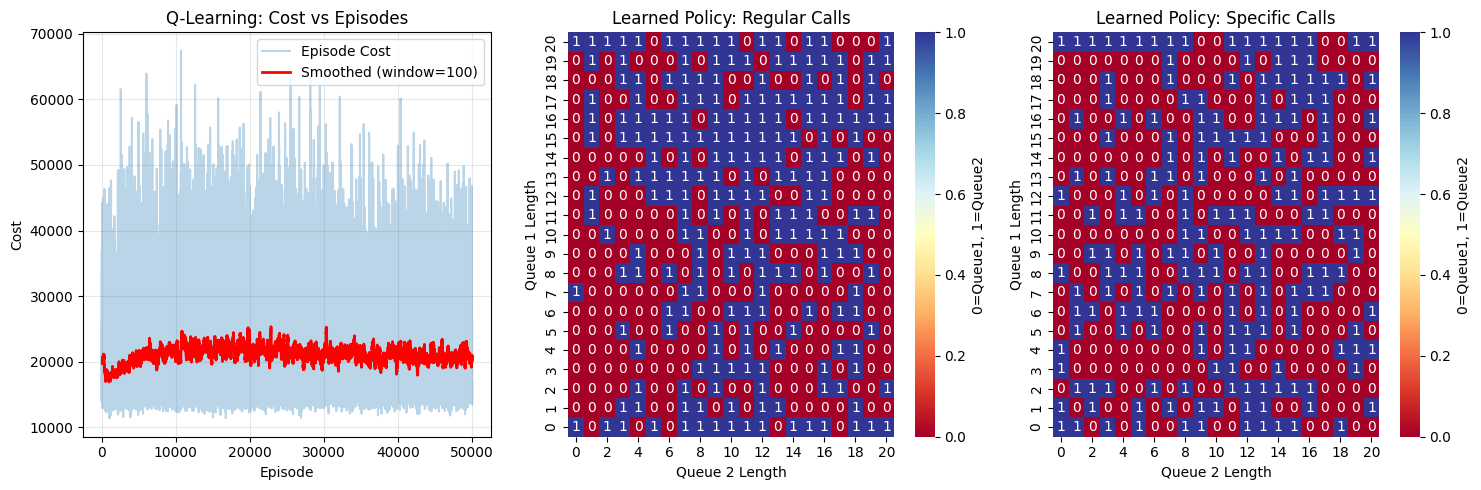

In [29]:
plot_results(costs, Q_table, max_queue_size)

In [31]:
def fixed_q_learning(
    env,
    num_episodes=20000,
    max_steps_per_episode=100,
    alpha=0.1,
    gamma=0.95,
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995,
    action_cost=10.0  # NEW: Cost per routing decision
):
    """
    Fixed Q-learning with proper cost structure and reward normalization.
    """
    
    # Initialize Q-table with zeros (better than random for cost minimization)
    Q = defaultdict(lambda: np.zeros(2))
    
    episode_costs = []
    episode_rewards = []
    optimal_action_counts = []
    epsilon = epsilon_start
    
    # Track learning progress
    learning_stats = {
        'states_visited': defaultdict(int),
        'total_decisions': 0,
        'optimal_decisions': 0,
        'total_calls_handled': 0
    }
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        total_cost = 0
        optimal_actions = 0
        total_actions = 0
        
        for step in range(max_steps_per_episode):
            learning_stats['states_visited'][state_tuple] += 1
            
            # Only make decisions when there are calls to route
            if len(env.pending_calls) > 0:
                learning_stats['total_calls_handled'] += 1
                total_actions += 1
                learning_stats['total_decisions'] += 1
                
                # Epsilon-greedy action selection
                if random.random() < epsilon:
                    action = random.choice([0, 1])
                    exploration = True
                else:
                    action = int(np.argmax(Q[state_tuple]))
                    exploration = False
                
                # Calculate what optimal action should be
                q1_len, q2_len, call_type_idx = state_tuple
                
                # Get expected waiting times for both queues
                wait_q1 = env.expected_waiting_time_binomial(0, call_type_idx) if q1_len < env.max_queue_size else float('inf')
                wait_q2 = env.expected_waiting_time_binomial(1, call_type_idx) if q2_len < env.max_queue_size else float('inf')
                
                optimal_choice = 0 if wait_q1 <= wait_q2 else 1
                if action == optimal_choice:
                    optimal_actions += 1
                    learning_stats['optimal_decisions'] += 1
                
                # Take action
                next_state, reward, terminated, truncated, info = env.step(action)
                next_state_tuple = tuple(next_state)
                
                # FIXED REWARD STRUCTURE:
                # 1. Penalize waiting time (normalize to reasonable range)
                waiting_penalty = reward / 100.0  # Scale down large waiting times
                
                # 2. Add action cost (routing cost)
                action_penalty = -action_cost
                
                # 3. Bonus for efficient decisions (no queue, no unnecessary action)
                if sum(state_tuple[:2]) == 0:  # No queues
                    efficiency_bonus = 5.0
                else:
                    efficiency_bonus = 0.0
                
                # 4. Heavy penalty for drops
                if info.get('dropped', False):
                    drop_penalty = -200.0
                else:
                    drop_penalty = 0.0
                
                # Combined reward
                combined_reward = waiting_penalty + action_penalty + efficiency_bonus + drop_penalty
                
                # Q-learning update
                if not (terminated or truncated):
                    best_next_action = np.argmax(Q[next_state_tuple])
                    td_target = combined_reward + gamma * Q[next_state_tuple][best_next_action]
                    td_error = td_target - Q[state_tuple][action]
                    
                    # Clip TD error to prevent instability
                    td_error = np.clip(td_error, -100.0, 100.0)
                    Q[state_tuple][action] += alpha * td_error
                else:
                    # Terminal state update
                    Q[state_tuple][action] += alpha * (combined_reward - Q[state_tuple][action])
                
                state_tuple = next_state_tuple
                total_reward += combined_reward
                total_cost += abs(combined_reward) if combined_reward < 0 else 0
                
            else:
                # No calls to route, just advance time
                next_state, reward, terminated, truncated, info = env.step(0)  # Default action
                state_tuple = tuple(next_state)
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(total_cost)
        episode_rewards.append(total_reward)
        
        # Track optimal action rate
        optimal_rate = optimal_actions / total_actions if total_actions > 0 else 0
        optimal_action_counts.append(optimal_rate)
        
        # Enhanced logging every 2000 episodes
        if (episode + 1) % 2000 == 0:
            recent_costs = episode_costs[-2000:]
            recent_rewards = episode_rewards[-2000:]
            recent_optimal = optimal_action_counts[-2000:]
            
            # Calculate learning statistics
            well_visited_states = len([s for s, count in learning_stats['states_visited'].items() if count > 10])
            overall_optimal_rate = learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1)
            
            print(f"\nEpisode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {np.mean(recent_costs):.2f} ± {np.std(recent_costs):.2f}")
            print(f"  Avg Reward (last 2000): {np.mean(recent_rewards):.2f}")
            print(f"  Optimal Action Rate (recent): {np.mean(recent_optimal):.3f}")
            print(f"  Optimal Action Rate (overall): {overall_optimal_rate:.3f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States with >10 visits: {well_visited_states}/{len(learning_stats['states_visited'])}")
            print(f"  Total Q-table states: {len(Q)}")
            print(f"  Total calls handled: {learning_stats['total_calls_handled']}")
            
            # Sample some Q-values for inspection
            if len(Q) > 0:
                print(f"  Sample Q-values:")
                sample_states = list(Q.keys())[:5]
                for s in sample_states:
                    q_vals = Q[s]
                    preference = "Q1" if q_vals[0] > q_vals[1] else "Q2"
                    diff = abs(q_vals[0] - q_vals[1])
                    print(f"    State{s}: Q1={q_vals[0]:6.2f}, Q2={q_vals[1]:6.2f}, Diff={diff:5.2f} -> {preference}")
    
    # Final summary
    print(f"\n{'='*60}")
    print("LEARNING SUMMARY:")
    print(f"Final optimal action rate: {learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1):.3f}")
    print(f"States explored: {len(Q)}")
    print(f"Well-visited states (>10 visits): {len([s for s, c in learning_stats['states_visited'].items() if c > 10])}")
    print(f"Average cost (last 1000): {np.mean(episode_costs[-1000:]):.2f}")
    print(f"Final epsilon: {epsilon:.4f}")
    print(f"Total calls handled: {learning_stats['total_calls_handled']}")
    
    return Q, episode_costs, episode_rewards, optimal_action_counts


# Alternative: Even simpler reward structure focused purely on costs
def simple_cost_focused_q_learning(
    env,
    num_episodes=20000,
    max_steps_per_episode=100,
    alpha=0.1,
    gamma=0.95,
    epsilon_start=0.8,
    epsilon_min=0.01,
    epsilon_decay=0.999
):
    """
    Ultra-simple Q-learning focused only on cost minimization.
    """
    Q = defaultdict(lambda: np.zeros(2))
    
    episode_costs = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_cost = 0
        
        for step in range(max_steps_per_episode):
            if len(env.pending_calls) > 0:
                state_tuple = tuple(state)
                
                # Epsilon-greedy
                if random.random() < epsilon:
                    action = random.choice([0, 1])
                else:
                    action = int(np.argmax(Q[state_tuple]))
                
                next_state, env_reward, terminated, truncated, info = env.step(action)
                
                # Simple cost-based reward
                if info.get('dropped', False):
                    reward = -100.0  # Heavy drop penalty
                else:
                    # Reward based on queue balance and waiting time
                    q1_len, q2_len = state_tuple[0], state_tuple[1]
                    
                    # Prefer balanced queues and shorter waits
                    queue_imbalance_penalty = -abs(q1_len - q2_len) * 2
                    waiting_penalty = env_reward / 50.0  # Scale down waiting time
                    routing_cost = -5.0  # Small routing cost
                    
                    reward = queue_imbalance_penalty + waiting_penalty + routing_cost
                
                # Q-update
                if not (terminated or truncated):
                    best_next_q = np.max(Q[tuple(next_state)])
                    Q[state_tuple][action] += alpha * (reward + gamma * best_next_q - Q[state_tuple][action])
                else:
                    Q[state_tuple][action] += alpha * (reward - Q[state_tuple][action])
                
                state = next_state
                total_cost += -reward
            else:
                # Skip if no calls
                state, _, terminated, truncated, _ = env.step(0)
                
            if terminated or truncated:
                break
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(total_cost)
        
        if (episode + 1) % 5000 == 0:
            avg_cost = np.mean(episode_costs[-5000:])
            print(f"Episode {episode+1}: Avg Cost = {avg_cost:.2f}, Epsilon = {epsilon:.3f}")
    
    return Q, episode_costs

In [34]:
# Test the fixed version
# print("TESTING FIXED Q-LEARNING:")
# Q_table_fixed, costs_fixed, rewards_fixed, optimal_rates_fixed = fixed_q_learning(
#     env,
#     num_episodes=20000,
#     max_steps_per_episode=100,
#     alpha=0.1,
#     action_cost=5.0,  # Moderate routing cost
#     epsilon_decay=0.995  # Faster exploration decay
# )

# Or try the ultra-simple version
print("\nTESTING SIMPLE VERSION:")
Q_table_simple, costs_simple = simple_cost_focused_q_learning(
    env,
    num_episodes=20000,
    alpha=0.15,
    epsilon_decay=0.998
)


TESTING SIMPLE VERSION:
Episode 5000: Avg Cost = 1244.61, Epsilon = 0.010
Episode 10000: Avg Cost = 972.44, Epsilon = 0.010
Episode 15000: Avg Cost = 967.87, Epsilon = 0.010
Episode 20000: Avg Cost = 966.34, Epsilon = 0.010


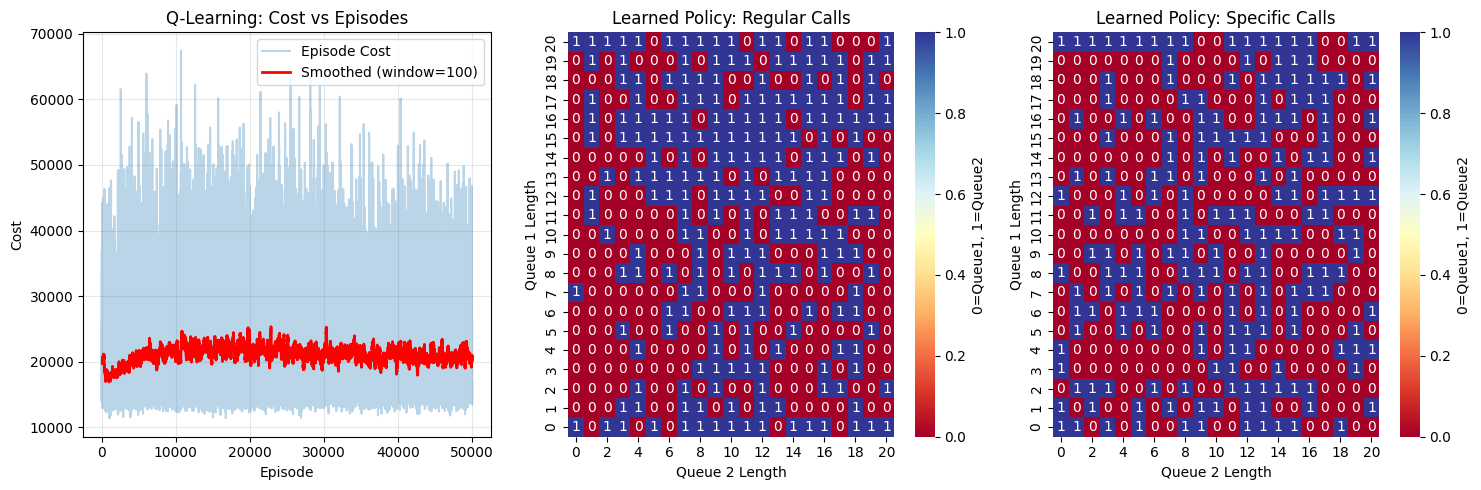

In [33]:
plot_results(costs, Q_table, max_queue_size)

### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO